# Divisions and ISMT
This notebook match each point of the dataset presented in the "Exploratory Data Analysis" notebook to a node in a Santiago Drive Graph obtained with Open Street Map.

In [2]:
import osmnx as ox
import networkx as nx
from datetime import timedelta
import pandas as pd
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
sns.set(style='darkgrid')

## Add new feature node id column
In this study, we have two datasets that need to be integrated. On one hand, we have our dataset presented in the "Exploratory Data Analysis" notebook, and on the other hand, an OpenStreetMap map of the city of Santiago.

Each row within our dataset needs to be paired with a corresponding node in OpenStreetMap. This merging process combines Santiago's graph structure with attribute values unique to each node. It's noteworthy that a single node on the Santiago map can be associated with multiple rows from the dataset.

In [4]:
G = ox.load_graphml("Maps/santiago_drive.graphml")
print(f'Number of nodes: {len(G.nodes())}')
print(f'Number of edges: {len(G.edges())}')

KeyboardInterrupt: 

In [ ]:
%%time
nodes_id = []
for _, row in tqdm(df.iterrows()):
    node = ox.distance.nearest_nodes(G, row.lon, row.lat)
    nodes_id.append(node)

df['node_id'] = nodes_id

In [ ]:
df.to_csv('dataset_nodes.csv', index=False)

## Find Administrative Division for each point

In [22]:
chile_division = gpd.read_file('../Data/Comunas/COMUNAS_2020.shp')
chile_division.head()

,CUT_REG,CUT_PROV,CUT_COM,REGION,PROVINCIA,COMUNA,SUPERFICIE,geometry
0,01,011,01101,Tarapacá,Iquique,Iquique,2289.53,"MULTIPOLYGON (((-70.11528 -21.17792, -70.11540..."
1,01,011,01107,Tarapacá,Iquique,Alto Hospicio,571.19,"POLYGON ((-69.92603 -20.25000, -69.96762 -20.3..."
2,01,014,01401,Tarapacá,Tamarugal,Pozo Almonte,13765.80,"POLYGON ((-68.99185 -19.92108, -68.98991 -19.9..."
3,01,014,01402,Tarapacá,Tamarugal,Camiña,2199.83,"POLYGON ((-69.39521 -19.06188, -69.39385 -19.0..."
4,01,014,01403,Tarapacá,Tamarugal,Colchane,4007.84,"POLYGON ((-68.65146 -19.77181, -68.65148 -19.7..."


<Axes: >

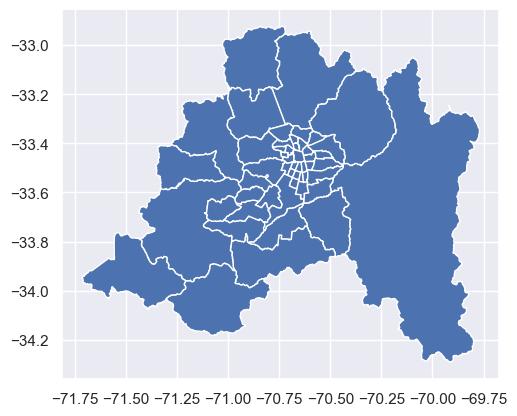

In [23]:
santiago_division = chile_division[chile_division.CUT_REG == '13']
santiago_division.plot()

In [24]:
santiago_values = pd.read_csv('../Data/dataset_nodes.csv')
santiago_values = gpd.GeoDataFrame(santiago_values, geometry=gpd.points_from_xy(santiago_values.lon,santiago_values.lat))
santiago_values.head(3)


,latlong,beautiful,boring,depressing,lively,safe,wealthy,lat,lon,comuna,node_id,geometry
0,"-33.323944,-70.51263428391168",-0.306948,1.565049,0.572029,-1.137733,-0.120456,-0.561887,-33.323944,-70.512634,Lo Barnechea,1396118148,POINT (-70.51263 -33.32394)
1,"-33.323944,-70.5127291",-0.421388,0.309495,0.368965,-0.098733,-0.103042,-0.162294,-33.323944,-70.512729,Lo Barnechea,1396118148,POINT (-70.51273 -33.32394)
2,"-33.323944,-70.51298714285714",0.116505,0.164284,-0.110312,0.063860,0.391172,0.226372,-33.323944,-70.512987,Lo Barnechea,1396115711,POINT (-70.51299 -33.32394)


In [25]:
def get_division(point) -> str:
    for com in santiago_division.geometry:
        if point.within(com):
            return com

tqdm.pandas()
santiago_values['division'] = santiago_values.geometry.progress_apply(get_division)

100%|██████████| 121351/121351 [00:53<00:00, 2248.18it/s]


In [26]:
santiago_division.head(3)

,CUT_REG,CUT_PROV,CUT_COM,REGION,PROVINCIA,COMUNA,SUPERFICIE,geometry
243,13,131,13115,Metropolitana de Santiago,Santiago,Lo Barnechea,1023.61,"POLYGON ((-70.33273 -33.10034, -70.33211 -33.1..."
244,13,132,13202,Metropolitana de Santiago,Cordillera,Pirque,444.71,"POLYGON ((-70.44598 -33.57922, -70.44519 -33.5..."
245,13,132,13203,Metropolitana de Santiago,Cordillera,San José de Maipo,4982.37,"POLYGON ((-69.86109 -34.11837, -69.86197 -34.1..."


In [27]:
santiago_with_divisions = santiago_values.merge(santiago_division[['geometry', 'COMUNA']], left_on='division', right_on='geometry')

In [28]:
santiago_with_divisions = santiago_with_divisions.drop(['geometry_x', 'division', 'geometry_y'], axis=1)
santiago_with_divisions = santiago_with_divisions.rename({'COMUNA':'division'}, axis=1)

In [29]:
santiago_with_divisions.to_csv('Data/dataset_santiago.csv', index=False)

In [5]:
df = pd.read_csv('Data/dataset_santiago.csv')
df.head()

,latlong,beautiful,boring,depressing,lively,safe,wealthy,lat,lon,comuna,node_id,division
0,"-33.323944,-70.51263428391168",-0.306948,1.565049,0.572029,-1.137733,-0.120456,-0.561887,-33.323944,-70.512634,Lo Barnechea,1396118148,Lo Barnechea
1,"-33.323944,-70.5127291",-0.421388,0.309495,0.368965,-0.098733,-0.103042,-0.162294,-33.323944,-70.512729,Lo Barnechea,1396118148,Lo Barnechea
2,"-33.323944,-70.51298714285714",0.116505,0.164284,-0.110312,0.063860,0.391172,0.226372,-33.323944,-70.512987,Lo Barnechea,1396115711,Lo Barnechea
3,"-33.323944,-70.51343609999999",-0.159113,-0.500987,-0.213503,0.635165,0.300856,0.453708,-33.323944,-70.513436,Lo Barnechea,9644543305,Lo Barnechea
4,"-33.323944,-70.51379769565217",-1.226162,1.176751,1.462015,-0.842954,-0.946355,-0.936168,-33.323944,-70.513798,Lo Barnechea,1735562917,Lo Barnechea


## Find ISMT values

In [6]:
df_ismt = gpd.read_file('Data/ISMT/ISMT.shp')
df_ismt.head(2)

,FID,region,nom_rgn,provinc,nm_prvn,comuna,nom_cmn,urbano,geocodg,redcode,...,AVE_GSE,ABC1,C2,C3,D,E,NSE,SHAPE_Leng,SHAPE_Area,geometry
0,1,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13107,HUECHURABA,HUECHURABA,1.310701e+10,13107011001,...,D,109,130,328,280,73,920,0.094783,0.000268,"POLYGON ((-70.65137 -33.35520, -70.65135 -33.3..."
1,2,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13402,BUIN,EL RULO,1.340206e+10,13402061001,...,D,23,40,129,332,119,643,0.079659,0.000084,"POLYGON ((-70.66374 -33.66766, -70.66394 -33.6..."


In [7]:
def get_ismt_data(point):
    for com in df_ismt.geometry:
        if point.within(com):
            return com

tqdm.pandas()
coords_point = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon,df.lat))
coords_point['geo_ismt'] = coords_point.geometry.progress_apply(get_ismt_data)

100%|██████████| 121351/121351 [16:13<00:00, 124.68it/s]


In [8]:
df_santiago_ismt = coords_point.merge(df_ismt[['geometry', 'prom_ismt', 'hogares', 'hog_40pct', 'pct_hog40p', 'AVE_GSE']], left_on='geo_ismt', right_on='geometry')

In [9]:
df_santiago_ismt = df_santiago_ismt.drop(['geometry_x', 'geometry_y', 'geo_ismt'], axis=1)
df_santiago_ismt.head(3)

,latlong,beautiful,boring,depressing,lively,safe,wealthy,lat,lon,comuna,node_id,division,prom_ismt,hogares,hog_40pct,pct_hog40p,AVE_GSE
0,"-33.323944,-70.51263428391168",-0.306948,1.565049,0.572029,-1.137733,-0.120456,-0.561887,-33.323944,-70.512634,Lo Barnechea,1396118148,Lo Barnechea,0.915742,1087.0,10,0.0092,ABC1
1,"-33.323944,-70.5127291",-0.421388,0.309495,0.368965,-0.098733,-0.103042,-0.162294,-33.323944,-70.512729,Lo Barnechea,1396118148,Lo Barnechea,0.915742,1087.0,10,0.0092,ABC1
2,"-33.323944,-70.51298714285714",0.116505,0.164284,-0.110312,0.063860,0.391172,0.226372,-33.323944,-70.512987,Lo Barnechea,1396115711,Lo Barnechea,0.915742,1087.0,10,0.0092,ABC1


## Check that everything is fine

In [14]:
print(f"Missing node ids: {df_santiago_ismt.node_id.isna().sum()}")
print(f"Missing divisions: {df_santiago_ismt.division.isna().sum()}")
print(f"Missing ISMT values: {df_santiago_ismt.prom_ismt.isna().sum()}")
print(f"Missing AVE_GSE values: {df_santiago_ismt.AVE_GSE.isna().sum()}")
print(f"Missing pct_hog40p values: {df_santiago_ismt.pct_hog40p.isna().sum()}")
print(f"Missing hog_40pct values: {df_santiago_ismt.hog_40pct.isna().sum()}")

Missing node ids: 0
Missing divisions: 0
Missing ISMT values: 0
Missing AVE_GSE values: 0
Missing pct_hog40p values: 0
Missing hog_40pct values: 0


## Save dataset in Data

In [15]:
df_santiago_ismt.to_csv('Data/dataset_santiago_ismt.csv', index=False)